# INICIALIZAÇÃO

In [47]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn import metrics
from prophet.plot import add_changepoints_to_plot,plot_cross_validation_metric
from prophet.diagnostics import performance_metrics,cross_validation
from statsmodels.tsa.stattools import adfuller

In [23]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)
df.index = pd.to_datetime(df.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex
df = df.asfreq('B')  # Defina a frequência como diária (ou ajuste para a frequência apropriada)

df_original = yf.download(symbol, start=start_date, end=end_date)
df_original.index = pd.to_datetime(df_original.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# MODELANDO DATAFRAME INICIAL PARA OS MODELOS

In [24]:
df.reset_index(inplace=True)
df = df[['Date','Close']]
df[['ds','y']] = df[['Date','Close']]
df.drop(columns=['Date','Close'], inplace=True)


In [25]:
m = Prophet()
m.add_country_holidays(country_name='BR')

In [26]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1733 entries, 0 to 1823
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1733 non-null   datetime64[ns]
 1   y       1733 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.6 KB


In [27]:
df

,ds,y
0,2017-01-02,59589.0
1,2017-01-03,61814.0
2,2017-01-04,61589.0
3,2017-01-05,62071.0
4,2017-01-06,61665.0
...,...,...
1818,2023-12-21,132182.0
1819,2023-12-22,132753.0
1821,2023-12-26,133533.0
1822,2023-12-27,134194.0


# PROPHET EXEMPLO1

AQUI NÓS VAMOS REALIZAR UM TREINO COM UMA FRAÇÃO ALEATORIA DOS DADOS, ISSO TENDE A SER UM POUCO MAIS EFICAZ QUE A SEPARAÇÃO POR DATA POIS MISTURA DADOS E REGISTROS DE DIVERSAS JANELAS DE TEMPO

In [28]:
train_set = df.sample(frac=0.8, random_state=0)
test_set = df.drop(train_set.index)
print(f'training data size : {train_set.shape}')
print(f'testing data size : {test_set.shape}')

training data size : (1386, 2)
testing data size : (347, 2)


In [29]:
m=Prophet()
m.fit(train_set)

20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing


e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-17,61187.420284,59372.264900,73588.372962,61187.420284,61187.420284,5258.661305,5258.661305,5258.661305,444.291023,444.291023,444.291023,4814.370282,4814.370282,4814.370282,0.0,0.0,0.0,66446.081588
1,2017-02-03,61900.312942,60206.479570,74794.462697,61900.312942,61900.312942,5552.300833,5552.300833,5552.300833,315.126126,315.126126,315.126126,5237.174707,5237.174707,5237.174707,0.0,0.0,0.0,67452.613775
2,2017-02-06,62026.117528,60752.499206,74772.489509,62026.117528,62026.117528,5514.561207,5514.561207,5514.561207,328.837308,328.837308,328.837308,5185.723899,5185.723899,5185.723899,0.0,0.0,0.0,67540.678735
3,2017-02-07,62068.052390,60594.007829,75093.255515,62068.052390,62068.052390,5610.078796,5610.078796,5610.078796,444.291023,444.291023,444.291023,5165.787773,5165.787773,5165.787773,0.0,0.0,0.0,67678.131186
4,2017-02-10,62193.856977,60800.530713,74896.677517,62193.856977,62193.856977,5401.541020,5401.541020,5401.541020,315.126126,315.126126,315.126126,5086.414894,5086.414894,5086.414894,0.0,0.0,0.0,67595.397997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-11-16,118885.874098,111671.070454,126320.535929,118885.874098,118885.874098,208.168594,208.168594,208.168594,282.734278,282.734278,282.734278,-74.565684,-74.565684,-74.565684,0.0,0.0,0.0,119094.042692
343,2023-11-21,119022.296547,112368.015684,127648.192586,119022.296547,119022.296547,897.216291,897.216291,897.216291,444.291023,444.291023,444.291023,452.925269,452.925269,452.925269,0.0,0.0,0.0,119919.512838
344,2023-12-06,119431.563894,113140.830936,128474.700962,119431.563894,119431.563894,1740.869417,1740.869417,1740.869417,134.830225,134.830225,134.830225,1606.039192,1606.039192,1606.039192,0.0,0.0,0.0,121172.433311
345,2023-12-20,119813.546751,114601.022652,129028.949514,119813.546751,119813.546751,1771.398366,1771.398366,1771.398366,134.830225,134.830225,134.830225,1636.568141,1636.568141,1636.568141,0.0,0.0,0.0,121584.945117


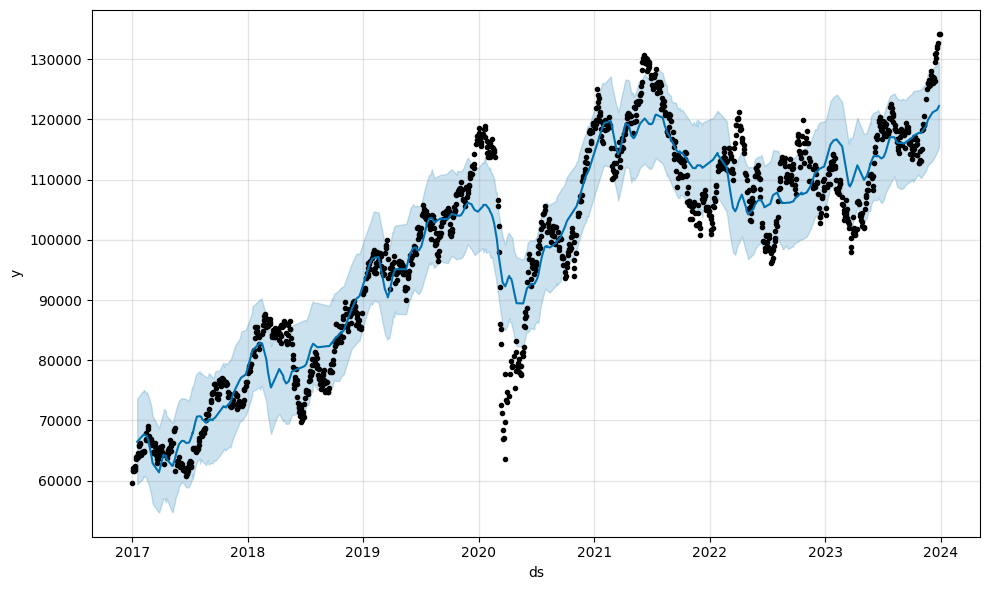

In [30]:
y_pred=m.predict(test_set)
m.plot(y_pred);
y_pred

In [31]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

MAE: 4608.5107843228625
RMSE: 5966.582656265659


O MAE é uma métrica que representa a média absoluta das diferenças entre as previsões do modelo e os valores reais. No seu caso, o valor do MAE é aproximadamente 4608.51. Isso significa que, em média, as previsões do seu modelo estão distantes dos valores reais por cerca de 4608.51 unidades na mesma escala dos dados originais.

O RMSE é uma métrica que leva em consideração a magnitude dos erros quadráticos. No seu caso, o valor do RMSE é aproximadamente 5966.58. Isso indica que, em média, as previsões do modelo estão distantes dos valores reais por cerca de 5966.58 unidades, penalizando erros maiores de forma mais significativa.

<Axes: xlabel='ds'>

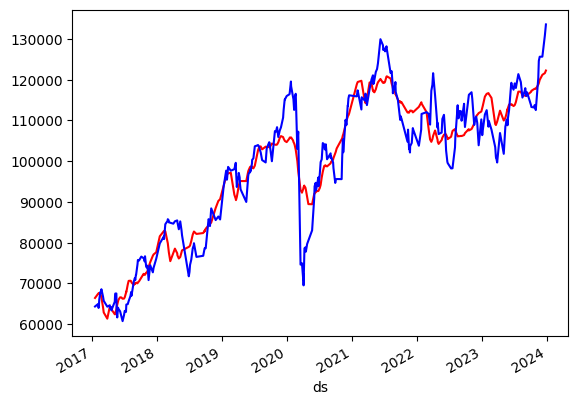

In [32]:
y_pred.set_index('ds')['yhat'].plot(color='red')
test_set.set_index('ds')['y'].plot(color='blue')

e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavi

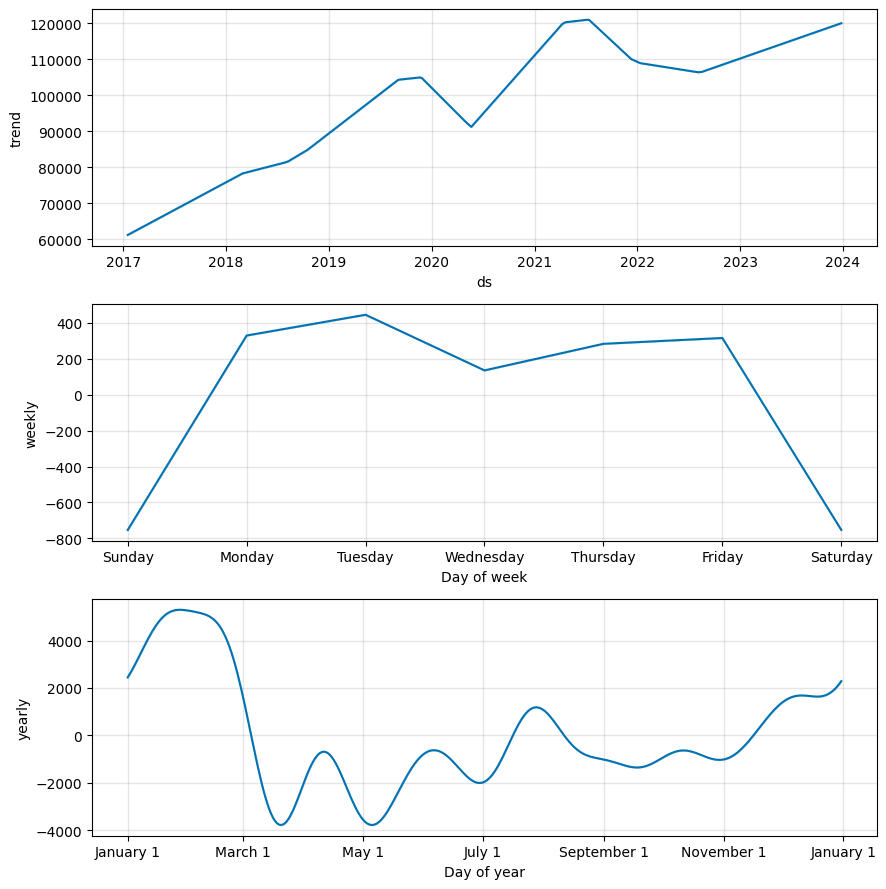

In [33]:
decompos = m.plot_components(y_pred)

In [34]:
df_cv = cross_validation(m,horizon='365 days')
report = performance_metrics(df_cv)
report
report['mape'].mean()

  0%|          | 0/6 [00:00<?, ?it/s]20:42:01 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:01,  3.28it/s]20:42:01 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:01,  2.95it/s]20:42:01 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  2.52it/s]20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:01<00:00,  2.30it/s]20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:03 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  2.27it/s]20:42:03 - cmdstanpy - INFO - Chain [1] start processing
20:42:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


0.16772292214318524

VALIDAÇÃO CRUZADA COM MAIS DETALHES

In [35]:
df_cv1 = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
report1 = performance_metrics(df_cv1)
report1
report1['mape'].mean()


  0%|          | 0/9 [00:00<?, ?it/s]20:42:04 - cmdstanpy - INFO - Chain [1] start processing
20:42:04 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:02,  3.08it/s]20:42:04 - cmdstanpy - INFO - Chain [1] start processing
20:42:04 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:02,  3.04it/s]20:42:04 - cmdstanpy - INFO - Chain [1] start processing
20:42:05 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:01<00:02,  2.67it/s]20:42:05 - cmdstanpy - INFO - Chain [1] start processing
20:42:05 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:01<00:01,  2.97it/s]20:42:05 - cmdstanpy - INFO - Chain [1] start processing
20:42:05 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:01<00:01,  2.76it/s]20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [00:02<00:01,  2.56it/s]20:42:06 - cmds

0.19109632556760225

PREVENDO FUTURO COM MODELO PROPHET

e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


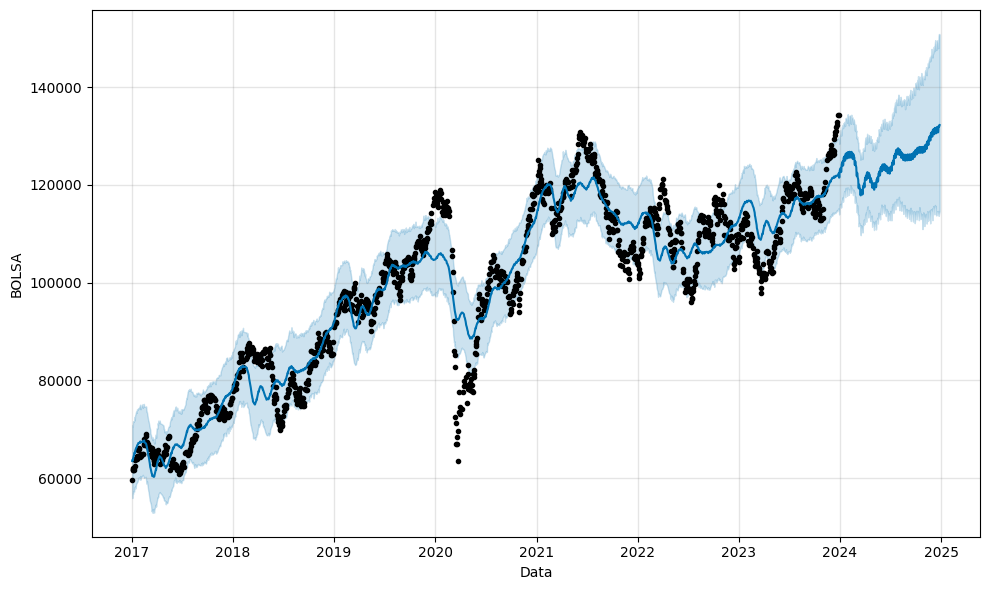

In [51]:
# determinar o período de dias para previsão
future = m.make_future_dataframe(periods=365)

# realizar a previsão para o período estabelecido
forecast = m.predict(future)

m.plot(forecast, xlabel='Data', ylabel='BOLSA');

# PROPHET EXEMPLO2

Aqui nós vamos separar o dataframe numa janela fixa de tempo e prever o futuro sem a mistura de dados na base de treino e comparar os resultados

In [55]:
# Defina a proporção desejada para a amostragem (por exemplo, 80% para treino)
proporcao_treino = 0.8

# Calcule o índice onde a divisão ocorrerá
indice_divisao = int(len(df) * proporcao_treino)

# Separe o DataFrame continuamente
train_set = df.iloc[:indice_divisao]
test_set = df.iloc[indice_divisao:]

print(f'training data size : {train_set.shape}')
print(f'testing data size : {test_set.shape}')

training data size : (1386, 3)
testing data size : (347, 3)


21:39:47 - cmdstanpy - INFO - Chain [1] start processing
21:39:48 - cmdstanpy - INFO - Chain [1] done processing
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-08-09,101031.086410,94392.696422,108346.245719,101031.086410,101031.086410,153.979236,153.979236,153.979236,-54.792104,-54.792104,-54.792104,208.771340,208.771340,208.771340,0.0,0.0,0.0,101185.065646
1,2022-08-10,100980.474120,94364.108505,107808.980958,100980.474120,100980.474120,24.928499,24.928499,24.928499,-19.776279,-19.776279,-19.776279,44.704779,44.704779,44.704779,0.0,0.0,0.0,101005.402619
2,2022-08-11,100929.861830,93672.366814,107172.802804,100929.861830,100929.861830,-257.117518,-257.117518,-257.117518,-137.507433,-137.507433,-137.507433,-119.610085,-119.610085,-119.610085,0.0,0.0,0.0,100672.744311
3,2022-08-12,100879.249539,93822.216989,108194.467862,100879.249539,100879.249539,-286.890255,-286.890255,-286.890255,-4.440208,-4.440208,-4.440208,-282.450047,-282.450047,-282.450047,0.0,0.0,0.0,100592.359285
4,2022-08-15,100727.412669,93114.843692,107015.900790,100727.412669,100727.412669,-823.064048,-823.064048,-823.064048,-76.787357,-76.787357,-76.787357,-746.276691,-746.276691,-746.276691,0.0,0.0,0.0,99904.348621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-12-21,75775.553635,36885.804014,112457.436036,38091.864246,111798.935832,121.844222,121.844222,121.844222,-137.507433,-137.507433,-137.507433,259.351655,259.351655,259.351655,0.0,0.0,0.0,75897.397857
343,2023-12-22,75724.941345,36658.880343,113433.958453,38011.893659,111885.957275,335.696937,335.696937,335.696937,-4.440208,-4.440208,-4.440208,340.137145,340.137145,340.137145,0.0,0.0,0.0,76060.638281
344,2023-12-26,75522.492184,38294.984718,113260.933949,37662.961719,111821.141847,742.347556,742.347556,742.347556,-54.792104,-54.792104,-54.792104,797.139660,797.139660,797.139660,0.0,0.0,0.0,76264.839740
345,2023-12-27,75471.879894,37016.856770,113717.000034,37465.866649,111908.163290,927.366521,927.366521,927.366521,-19.776279,-19.776279,-19.776279,947.142800,947.142800,947.142800,0.0,0.0,0.0,76399.246415


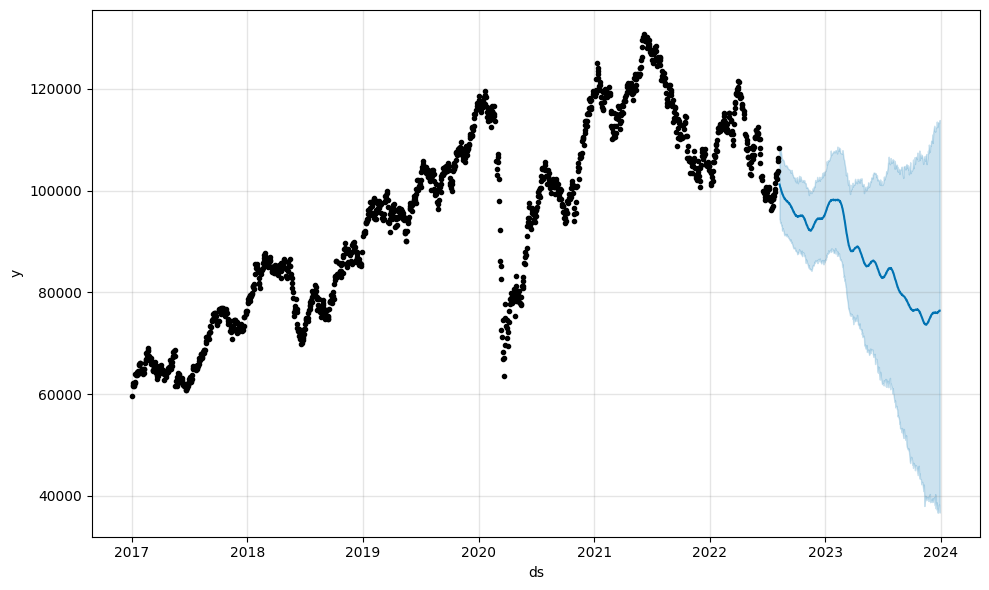

In [56]:
#Instanciando modelo
m=Prophet()
m.fit(train_set)

#Prevendo base test_set
y_pred=m.predict(test_set)
m.plot(y_pred);
y_pred

<Axes: xlabel='ds'>

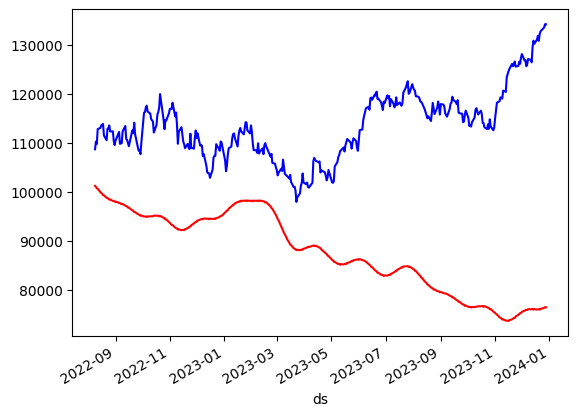

In [57]:
y_pred.set_index('ds')['yhat'].plot(color='red')
test_set.set_index('ds')['y'].plot(color='blue')

In [58]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

MAE: 25798.794655309845
RMSE: 29117.63804904347
